# NI DAQ for SCF measurement

In [1]:
import LDAQ #custom version of LDAQ --> should be installed properly via pip
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt

In [2]:
# Simulation was used before first test structure was created

#def simulate_signal(t, f1, f2):
#    """
#    first argument must be time.
#    If multi_processing is True, then the function must be pickable and
#    all libraries must be imported inside the function.
#    """
#    #import numpy as np
#    sig1 = np.sin(2*np.pi*f1*t) + np.random.rand(len(t))*0.3
#    sig2 = np.cos(2*np.pi*f2*t) + np.random.rand(len(t))*0.3
#    return np.array([sig1, sig2]).T
#
#fs = 1_000_000
#acq_simulated = LDAQ.simulator.SimulatedAcquisition(acquisition_name='sim')
#acq_simulated.set_simulated_data(simulate_signal, channel_names=["ch1", "ch2"], sample_rate=fs, args=(84, 120)) # use function
#acq_simulated.run_acquisition(1.0)

## Set up NI Task with proper device

NI DAQmx is not that great at reporting errors, as it most often just prints an error codes.
The following link provides a table with a significant portion of them: [NI DAQmx Error Codes](https://www.ni.com/docs/de-DE/bundle/ni-daqmx-.net-framework-4.5.1-class-library-getting-started/page/netdaqmxerrorcodes.html?srsltid=AfmBOorhJXnpL0L-iZN-NrHwVux-ycAtkvdSPi9XsSREz3_EgUCeEQ5V)

In [3]:
input_task_name = "ni_input_task"
acquisition_name = input_task_name + "_acq"
fs = 1_000_000
#fs = 500_000

ni_task = LDAQ.national_instruments.NITask(input_task_name, sample_rate=fs)
ni_task

Task name: ni_input_task
Connected devices:
	(0) - cDAQ1
	(1) - cDAQ1Mod3
	(2) - cDAQ1Mod4
	(3) - SimDev1
Channels: []

In [4]:
device_names = ["cDAQ1Mod3", "cDAQ1Mod4"]
device_ids = [ni_task.device_list.index(device_name) for device_name in device_names]

In [5]:
num_channels_available = 0
for id in device_ids:
    num_channels_available += len(ni_task.system.devices[id].ai_physical_chans)
num_channels_per_device = num_channels_available / len(device_ids)

num_channels = 6

# check if there are enough devices for the amount of channels
assert num_channels <= num_channels_available, f"Not enough channels available on the selected devices. Desired: {num_channels}, Available: {num_channels_available}"

for i in range(0, num_channels):
    current_device_id = device_ids[int(np.floor(i / num_channels_per_device))]
    channel_ind = int(i % num_channels_per_device)

    ni_task.add_channel(channel_name=f"ch{i+1}", device_ind=current_device_id, channel_ind=channel_ind, scale=1.0, units="V", min_val=-10.0, max_val=10.0)

ni_task

Task name: ni_input_task
Connected devices:
	(0) - cDAQ1
	(1) - cDAQ1Mod3
	(2) - cDAQ1Mod4
	(3) - SimDev1
Channels: ['ch1', 'ch2', 'ch3', 'ch4', 'ch5', 'ch6']

In [6]:
acq_ni = LDAQ.national_instruments.NIAcquisition(task_name=ni_task, acquisition_name=acquisition_name)
acq_ni

Acquisition name:     ni_input_task_acq
Number of channels:   0
Data channels:        []
Video channels:       []
Sample rate:          1000000 Hz
Continuous mode:      False
Standalone:           True

## Set up visualization from LDAQ
Sometimes has to be run a second time after running ldaq to be set up properly. At the moment not yet sure why

In [7]:
vis = LDAQ.Visualization(refresh_rate=50)

for i in range(0, num_channels):
    vis.add_lines((i,0), source=acquisition_name, channels=i, t_span=1.0)

for i in range(1, num_channels):
    vis.config_subplot((i, 0), linked_axis=(0, 0))

## Creat Core object with acquisition & visualization

In [8]:
ldaq = LDAQ.Core(acquisitions=acq_ni, visualization=vis)
#ldaq = LDAQ.Core(acquisitions=[acq_ni])

# Set the trigger on the input task
#ldaq.set_trigger(source=acquisition_name, channel=0, level=0.100, duration=1.0, presamples=50)

ldaq

Acquisition sources (index, name):
	0 - ni_input_task_acq

Generation sources (index, name):
	None

Additional check events:
	None

Trigger settings:
	- duration [sec]      None
	- source              None
	- channel             None
	- level               None
	- presamples          None
	- type                None

In [12]:
ldaq.run(1.0, autoclose=False)
#ldaq.run()

closing app
closing app


## Extract data from measurement dict

In [54]:
measurement = ldaq.get_measurement_dict()
data = measurement[acquisition_name]
data

{'time': array([0.00000e+00, 1.00000e-06, 2.00000e-06, ..., 9.99997e-01,
        9.99998e-01, 9.99999e-01], shape=(1000000,)),
 'channel_names': ['ch1', 'ch2', 'ch3', 'ch4', 'ch5', 'ch6'],
 'data': array([[-0.00186967,  0.00273526,  0.00280364,  0.00921757, -0.00323472,
          0.00057019],
        [-0.00049818,  0.00965168,  0.00419213,  0.00509928,  0.00230745,
          0.00196027],
        [ 0.0022448 ,  0.00273526,  0.00419213,  0.00372651,  0.00092191,
          0.00335035],
        ...,
        [-0.00049818,  0.00688511,  0.00419213,  0.00509928,  0.00507854,
          0.00196027],
        [ 0.00361629,  0.0082684 ,  0.00419213,  0.00509928, -0.00184918,
          0.01030075],
        [ 0.00498778,  0.00965168,  0.00280364,  0.00509928, -0.00046363,
          0.00057019]], shape=(1000000, 6)),
 'sample_rate': 1000000}

In [ ]:
#data = loaded_data[acquisition_name]
time = data["time"]
fs = data["sample_rate"]
raw_data = data["data"]


ch1_data = raw_data[:, data["channel_names"].index("ch1")]
ch2_data = raw_data[:, data["channel_names"].index("ch2")]
ch3_data = raw_data[:, data["channel_names"].index("ch3")]
ch4_data = raw_data[:, data["channel_names"].index("ch4")]
ch5_data = raw_data[:, data["channel_names"].index("ch5")]
ch6_data = raw_data[:, data["channel_names"].index("ch6")]

In [18]:
def rms(data):
    return np.sqrt(np.mean(data**2))

rms_values = np.empty((num_channels,))
mean_values = np.empty((num_channels,))
max_values = np.empty((num_channels,))

for i in range(0, num_channels):
    current_data = raw_data[:, data["channel_names"].index(f"ch{i+1}")]
    rms_values[i] = rms(current_data)
    mean_values[i] = np.mean(current_data)
    max_values[i] = np.max(np.abs(current_data))

    print(f"RMS of channel ch{i+1}: {rms_values[i]:.5f} V = {rms_values[i]*1e3:.2f} mV / mean: {mean_values[i]*1e3:.2f}")

print(f"Mean RMS value is:  {np.mean(rms_values):.5f} V = {np.mean(rms_values)*1e3:.2f} mV")

print(f"Max value for all data is: {np.max(max_values):.5f} V = {np.max(max_values)*1e3:.2f} mV")

max_idx = np.argmax(rms_values)
print(f"Estimated max noise amplitude is: {(3.3*rms_values[max_idx] + mean_values[max_idx])*1e3:.2f} mV") #Amplitude is smaller than 3.3 sigma for 99.9% of all samples would require mean to be 0

RMS of channel ch1: 0.00294 V = 2.94 mV / mean: 0.49
RMS of channel ch2: 0.00462 V = 4.62 mV / mean: 3.96
RMS of channel ch3: 0.00350 V = 3.50 mV / mean: 1.93
RMS of channel ch4: 0.00449 V = 4.49 mV / mean: 3.54
RMS of channel ch5: 0.00272 V = 2.72 mV / mean: -1.08
RMS of channel ch6: 0.00300 V = 3.00 mV / mean: 1.30
Mean RMS value is:  0.00355 V = 3.55 mV
Max value for all data is: 0.02224 V = 22.24 mV
Estimated max noise amplitude is: 19.22 mV


In [57]:
ldaq.save_measurement("impact_sample_2", root="data", timestamp=True)

'data\\20250402_145519_impact_sample_2.pkl'

In [9]:
loaded_data = LDAQ.utils.load_measurement("20250402_145519_impact_sample_2.pkl", directory="data")
loaded_data

{'ni_input_task_acq': {'time': array([0.00000e+00, 1.00000e-06, 2.00000e-06, ..., 9.99997e-01,
         9.99998e-01, 9.99999e-01], shape=(1000000,)),
  'channel_names': ['ch1', 'ch2', 'ch3', 'ch4', 'ch5', 'ch6'],
  'data': array([[-0.00186967,  0.00273526,  0.00280364,  0.00921757, -0.00323472,
           0.00057019],
         [-0.00049818,  0.00965168,  0.00419213,  0.00509928,  0.00230745,
           0.00196027],
         [ 0.0022448 ,  0.00273526,  0.00419213,  0.00372651,  0.00092191,
           0.00335035],
         ...,
         [-0.00049818,  0.00688511,  0.00419213,  0.00509928,  0.00507854,
           0.00196027],
         [ 0.00361629,  0.0082684 ,  0.00419213,  0.00509928, -0.00184918,
           0.01030075],
         [ 0.00498778,  0.00965168,  0.00280364,  0.00509928, -0.00046363,
           0.00057019]], shape=(1000000, 6)),
  'sample_rate': 1000000}}

In [61]:
from sdypy_sep005.sep005 import assert_sep005
from data_converter import measurement_dict_to_sep005

#data_sep005 = measurement_dict_to_sep005(loaded_data)
data_sep005 = measurement_dict_to_sep005(measurement)
assert_sep005(data_sep005)

data_sep005

{'name': 'ni_input_task_acq',
 'data': array([[-0.00186967,  0.00273526,  0.00280364,  0.00921757, -0.00323472,
          0.00057019],
        [-0.00049818,  0.00965168,  0.00419213,  0.00509928,  0.00230745,
          0.00196027],
        [ 0.0022448 ,  0.00273526,  0.00419213,  0.00372651,  0.00092191,
          0.00335035],
        ...,
        [-0.00049818,  0.00688511,  0.00419213,  0.00509928,  0.00507854,
          0.00196027],
        [ 0.00361629,  0.0082684 ,  0.00419213,  0.00509928, -0.00184918,
          0.01030075],
        [ 0.00498778,  0.00965168,  0.00280364,  0.00509928, -0.00046363,
          0.00057019]], shape=(1000000, 6)),
 'time': array([0.00000e+00, 1.00000e-06, 2.00000e-06, ..., 9.99997e-01,
        9.99998e-01, 9.99999e-01], shape=(1000000,)),
 'fs': 1000000,
 'channel_name': ['ch1', 'ch2', 'ch3', 'ch4', 'ch5', 'ch6'],
 'unit_str': ''}

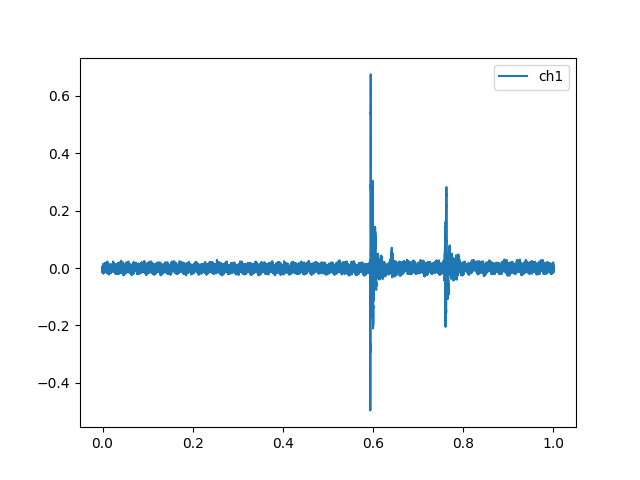

In [52]:
%matplotlib widget
plt.clf()
plt.plot(time, ch1_data)
plt.legend(["ch1"])
plt.show()

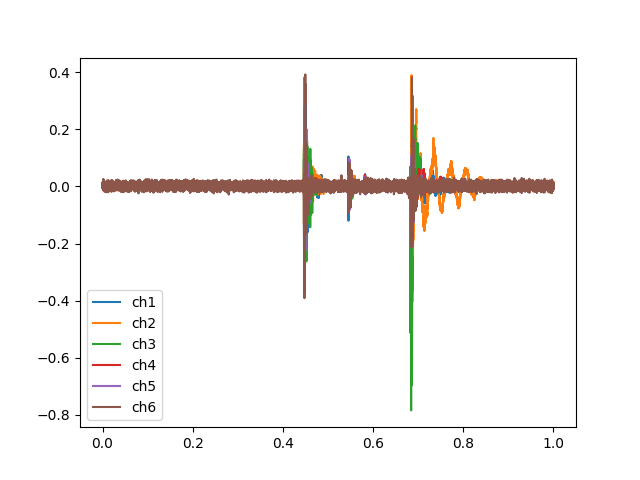

In [24]:
%matplotlib widget
plt.clf()
plt.plot(time, ch1_data, time, ch2_data, time, ch3_data, time, ch4_data, time, ch5_data, time, ch6_data)
plt.legend(["ch1", "ch2", "ch3", "ch4", "ch5", "ch6"])
plt.show()

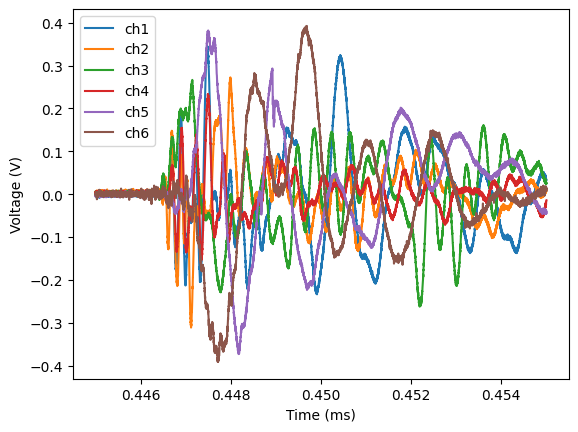

In [32]:
times = np.array([0.445, 0.455])
#times = np.array([0.685, 0.690])
indices = (times * fs).astype(int)
start, end = indices[0], indices[1]

%matplotlib inline
plt.figure()
plt.plot(time[start:end], ch1_data[start:end],
         time[start:end], ch2_data[start:end],
         time[start:end], ch3_data[start:end],
         time[start:end], ch4_data[start:end],
         time[start:end], ch5_data[start:end],
         time[start:end], ch6_data[start:end])
plt.xlabel("Time (ms)")
plt.ylabel("Voltage (V)")
plt.legend(["ch1", "ch2", "ch3", "ch4", "ch5", "ch6"])
plt.show()

Text(0, 0.5, 'Voltage (V)')

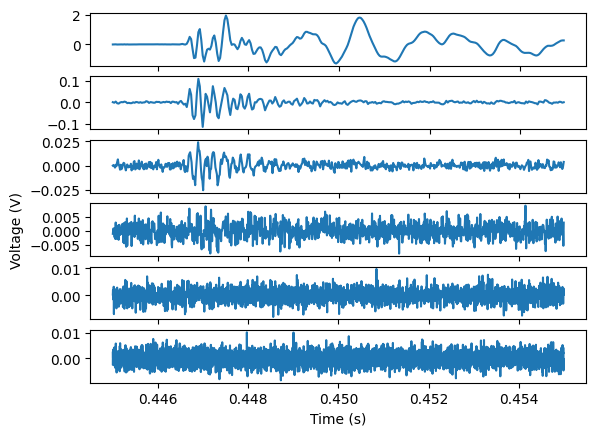

In [43]:
import pywt

coeffs = pywt.wavedec(ch1_data, 'db2', level=5)
pywt.coeffs_to_array

cA5, cD5, cD4, cD3, cD2, cD1 = coeffs

fig, axs = plt.subplots(6, 1)
for i, c in enumerate(coeffs):
    start_wavelet = int(start / len(time) * len(c))
    end_wavelet = int(end / len(time) * len(c))

    loc_time = np.linspace(time[0], time[-1], c.shape[0])
    axs[i].plot(loc_time[start_wavelet:end_wavelet], c[start_wavelet:end_wavelet])

axs[-1].set_xlabel("Time (s)")
axs[len(axs)//2].set_ylabel("Voltage (V)")

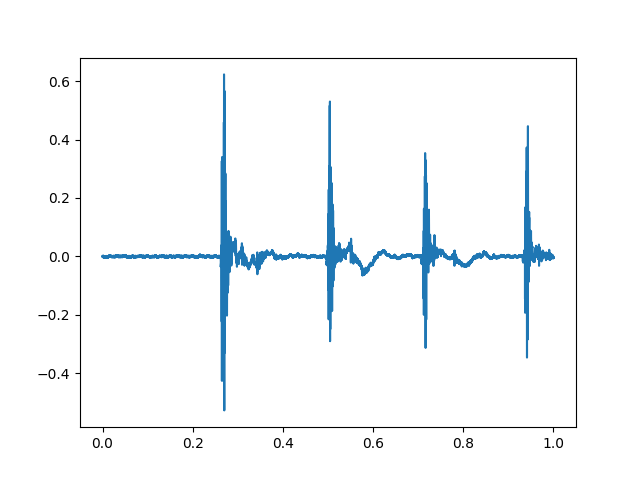

In [32]:
from scipy.signal import butter, lfilter, freqz

def butterworth_lp_filt(data, cutoff, fs, order=5):
    b, a = butter(order, cutoff, fs=fs, btype="lowpass", analog=False)
    y = lfilter(b, a, data)
    return y

f_cutoff = 25_000
ch1_data_filt = butterworth_lp_filt(ch1_data, f_cutoff, fs)

plt.clf()
plt.plot(time, ch1_data_filt)
plt.show()